<a href="https://colab.research.google.com/github/usneek/Blog-sentiment-analysis/blob/main/sentiment_score_with_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle kernels output stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm 

Output file downloaded to /content/Model Weights/checkpoint
Output file downloaded to /content/Model Weights/weights.data-00000-of-00001
Output file downloaded to /content/Model Weights/weights.index
Output file downloaded to /content/Sentiment-BiLSTM/saved_model.pb
Output file downloaded to /content/Sentiment-BiLSTM/variables/variables.data-00000-of-00001
Output file downloaded to /content/Sentiment-BiLSTM/variables/variables.index
Output file downloaded to /content/Tokenizer.pickle
Output file downloaded to /content/Word2Vec-twitter-100
Output file downloaded to /content/Word2Vec-twitter-100-trainable
Kernel log downloaded to /content/twitter-sentiment-analysis-using-word2vec-bilstm.log 


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

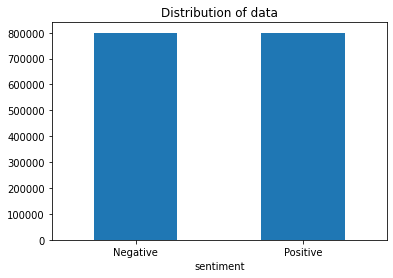

In [ ]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"


In [ ]:
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 38.3 s, sys: 244 ms, total: 38.5 s
Wall time: 39.5 s


In [ ]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  that s a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he can t update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it s not behaving at all  i m mad  why am i here  because i can t see you all over t

In [ ]:
from sklearn.model_selection import train_test_split
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

In [ ]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [ ]:
Embedding_dimensions=100
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [ ]:
list_tokens=[]
for i in range(60000):
  list_tokens.append(" ")
for word, token in tokenizer.word_index.items():
   if word2vec_model.wv.__contains__(word):
     list_tokens[token]=word

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
list(swn.senti_synsets('slow'))
sentence='It was a really good day'
from nltk.tag import pos_tag
token = nltk.word_tokenize(sentence)
after_tagging = nltk.pos_tag(token)
print (token)
print (after_tagging)
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
sentiment = 0.0
tokens_count = 0
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['It', 'was', 'a', 'really', 'good', 'day']
[('It', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('really', 'RB'), ('good', 'JJ'), ('day', 'NN')]


In [ ]:
def sentiment_value(after_tagging):
  sentiment_vector=[]
  for word, tag in after_tagging:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                sentiment_vector.append(1.0)
                continue
  
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                sentiment_vector.append(1.0)
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                sentiment_vector.append(1.0)
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_vector.append(1+swn_synset.pos_score() + swn_synset.neg_score())
  return sentiment_vector

In [ ]:
sentiments=[]
after_tagging = nltk.pos_tag(list_tokens)
sentiments.append(np.array(sentiment_value(after_tagging)))

In [ ]:
sentiment_score = np.array(sentiments)

In [ ]:
final_matrix=np.multiply(embedding_matrix,sentiment_score.T)

In [ ]:
final_matrix.shape

(60000, 100)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[final_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        attention(return_sequences=True),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        attention(return_sequences=True),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
from keras import backend as K
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 attention (attention)       (None, 60, 200)           260       
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 60, 200)           260       
                                                                 
 conv1d (Conv1D)             (None, 56, 100)       

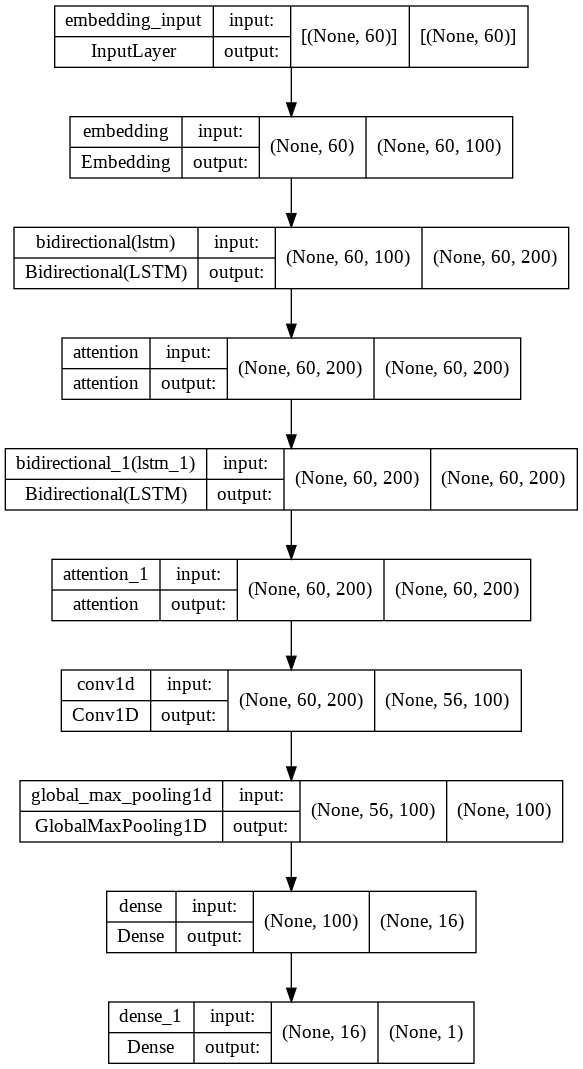

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='/content/bilstm_attention.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

In [ ]:
# training_model.save_weights('drive/MyDrive/IR assignment/weight2.h5')

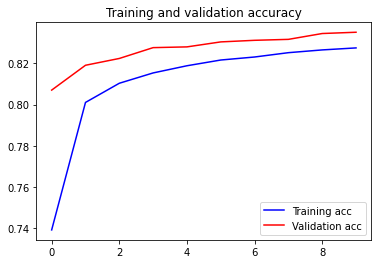

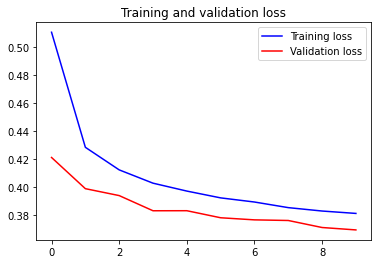

In [ ]:
# acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
# loss, val_loss = history.history['loss'], history.history['val_loss']
# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

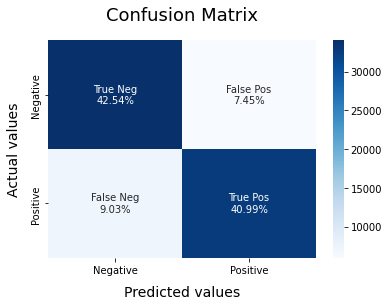

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     39989
           1       0.85      0.82      0.83     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [ ]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets


INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_model.load_weights('drive/MyDrive/IR assignment/weight1.h5')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

extractor = keras.Model(inputs=training_model.inputs,
                        outputs=[layer.output for layer in training_model.layers])

In [ ]:
features = extractor(X_data)

In [ ]:
inter_output_model = keras.Model(model.input, model.get_layer(index = 3).output )

In [ ]:
intermediate_from_a = training_model.get_layer("embedding").output

In [ ]:
intermediate_from_a[0]

<KerasTensor: shape=(60, 100) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:
matrix = np.ones((X_data.shape[0], final_matrix.shape[0]))